In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)}, font_scale=1.5)

In [2]:
def load_df_from_datasets(location_prefix, number):
    target_file = "{}_{}.csv".format(location_prefix, number)
    df = pd.read_csv(target_file)
    df = df.rename(columns={'Unnamed: 0':'time'})
    df['time'] = pd.to_datetime(df['time'])
    df['time'] = df['time'].dt.tz_localize(None)
    df = df.set_index('time')
    df["LogPower"] = np.log(df["Power"] + 2)
    
    return df
  
basic_df = load_df_from_datasets("../data/raw/synthetic_basic/Synthetic_Basic", 1)    
soil_df  = load_df_from_datasets("../data/raw/synthetic_soil/Synthetic_Soil", 1)
soil_weather_df = load_df_from_datasets("../data/raw/synthetic_soil_weather/Synthetic_Soil_and_Weather", 1)



In [3]:
soil_D = soil_df.resample("D").mean()
soil_Y_roll = soil_df.rolling("365D").mean()

basic_D = basic_df.resample("D").mean()
basic_Y_roll = basic_df.rolling("365D").mean()

basic_D = basic_df.resample("D").mean()
basic_Y_roll = basic_df.rolling("365D").mean()

/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


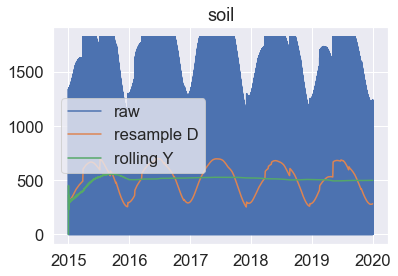

In [4]:
fig, ax = plt.subplots()
ax.plot(soil_df["Power"], label='raw')
ax.plot(soil_D["Power"], label='resample D')
ax.plot(soil_Y_roll["Power"], label="rolling Y")
ax.set_title("soil")
ax.legend()

/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


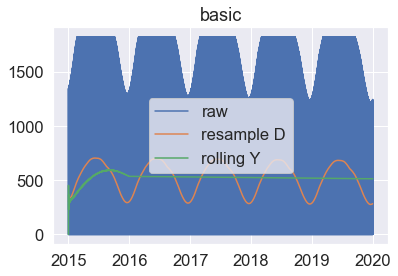

In [5]:
fig, ax = plt.subplots()
ax.plot(basic_df["Power"], label='raw')
ax.plot(basic_D["Power"], label='resample D')
ax.plot(basic_Y_roll["Power"], label="rolling Y")
ax.set_title("basic")
ax.legend()

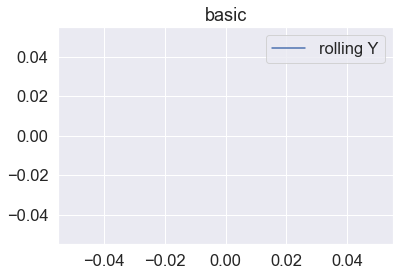

In [6]:
fig, ax = plt.subplots()
ax.plot(basic_D["LogPower"].values[60*24*365:], label="rolling Y")
ax.set_title("basic")
ax.legend()

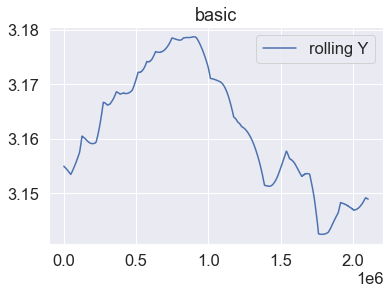

In [7]:
fig, ax = plt.subplots()
ax.plot(soil_Y_roll["LogPower"].values[60*24*365:], label="rolling Y")
ax.set_title("basic")
ax.legend()

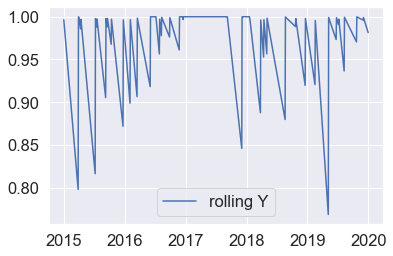

In [8]:
fig, ax = plt.subplots()
ax.plot(soil_D["soiling"], label="rolling Y")
ax.legend()

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
basic_houry = basic_df["Power"].resample("H").mean()



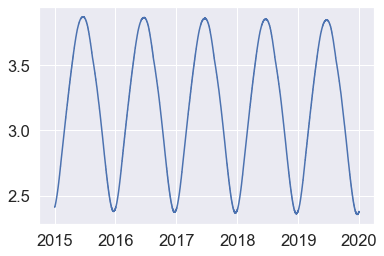

In [10]:
results = seasonal_decompose(basic_df["LogPower"].resample("H").mean(), model="additive")
plt.plot(results.trend)

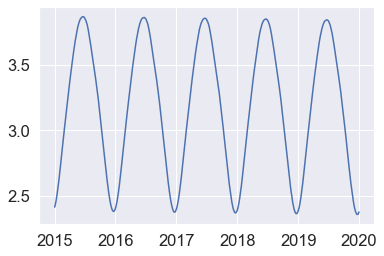

In [11]:
results2 = seasonal_decompose(results.trend[12:-12], model="additive")
plt.plot(results2.trend)

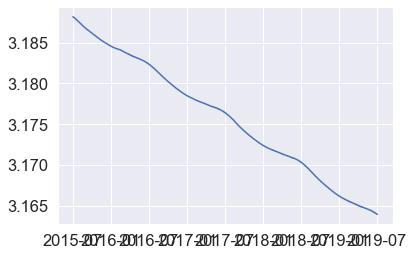

In [12]:
data = basic_df["LogPower"].resample("H").mean()
daily_seasonality = seasonal_decompose(data, model="additive", period=24)
data_d = data - daily_seasonality.seasonal
no_season = seasonal_decompose(data_d, model="additive", period=24*365)
plt.plot(no_season.trend)

In [13]:
from scipy import stats

In [14]:

y = no_season.trend.dropna()
x = np.arange(y.size)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

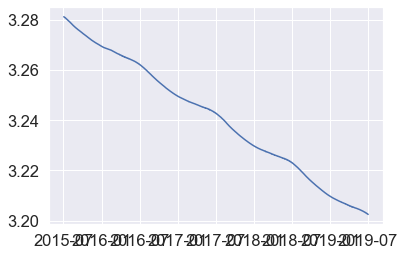

In [15]:
plt.plot(np.exp(y-2))

In [16]:
multiplicative_trend  = np.exp(y-2)

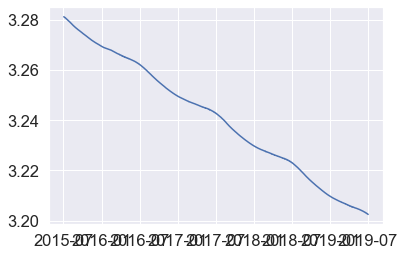

In [17]:
plt.plot(multiplicative_trend)

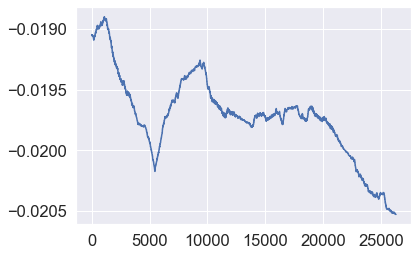

In [18]:
plt.plot((multiplicative_trend[24*365:].values-multiplicative_trend[:-24*365].values))

In [19]:
# plt.plot(soil_df["soiling"])np.log(1+soil_df["Degradation_rate_per_yr"])
# #plt.plot((1+soil_df["Degradation_rate_per_yr"]))

SyntaxError: invalid syntax (<ipython-input-19-f351fe08615e>, line 1)

In [20]:
soil_df["Ordinal_range"] = np.arange(len(soil_df.index))
soil_df["Ordinal_range"] = soil_df["Ordinal_range"]/(60*24*365)

In [21]:
soil_signal = soil_df["soiling"]*(1+soil_df["Degradation_rate_per_yr"]*soil_df["Ordinal_range"])

In [22]:
log_soil_signal = np.log(soil_signal)


In [23]:
import statsmodels.api as sm

In [24]:
unrestricted_model = {
    'level': 'local linear trend'
}

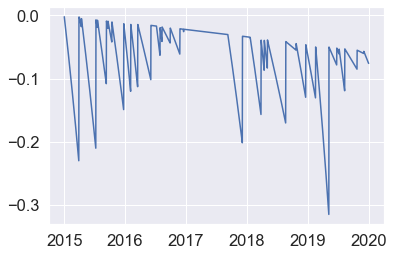

In [25]:
plt.plot(log_soil_signal.resample("H").mean())

In [26]:
output_mod = sm.tsa.UnobservedComponents(log_soil_signal.resample("H").mean(), **unrestricted_model)
output_res = output_mod.fit(method="powell", disp=False)

In [27]:
print(output_res.summary())

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                43824
Model:             local linear trend   Log Likelihood              336157.860
Date:                Fri, 07 Aug 2020   AIC                        -672309.719
Time:                        11:39:48   BIC                        -672283.656
Sample:                    01-01-2015   HQIC                       -672301.505
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.323e-30   7.77e-12    1.7e-19      1.000   -1.52e-11    1.52e-11
sigma2.level      2.664e-27   1.42e-11   1.88e-16      1.000   -2.78e-11    2.78e-11
sigma2.trend      1.263e-08 

/Users/darrenvalentine/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/statsmodels/tsa/statespace/structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


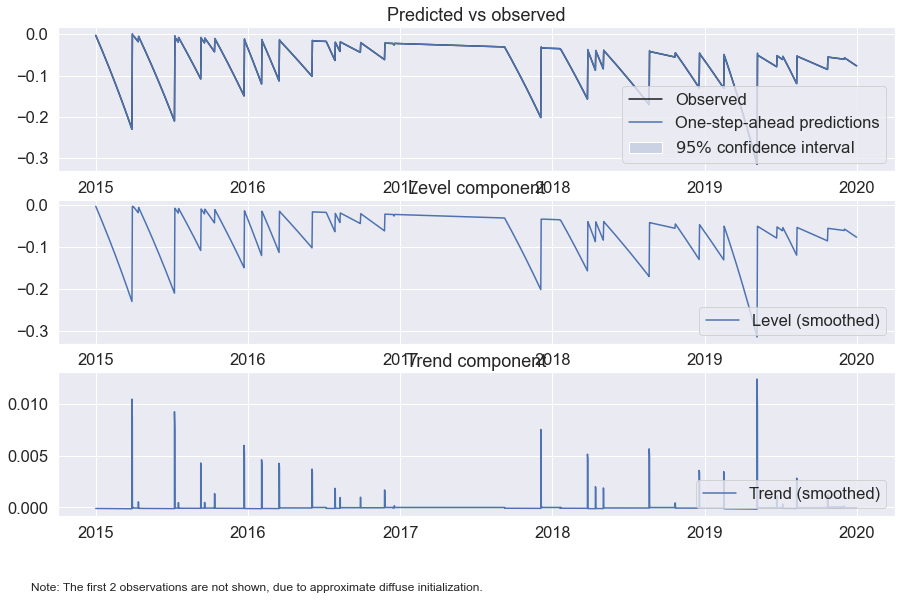

In [28]:
fig = output_res.plot_components(legend_loc='lower right', figsize=(15, 9));

